In [63]:
%load_ext autoreload
%autoreload 2
import os
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF1_T256_H05_tl_110data_StbleTgt_WRMSE import \
    get_config
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF2_HighFTh_T256_H05_tl_110data_StbleTgt_WRMSE import get_config
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_StbleTgt_WRMSE import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
config = get_config()
assert config.deltaT == 1./256
num_paths = 10952

In [65]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape == y_pred.shape and len(y_pred.shape) == 1)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return (np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [66]:
if "fQuadSin" in config.data_path:
    minx = -1.5
    if config.sin_space_scale == 25.:
        ts_type = "fQuadSin2"
    else:
        ts_type = "fQuadSin1"
    include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
elif "fBiPotSmall" in config.data_path:
    minx = -1.5
    ts_type = "fBiPotSmall"
    include = None
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    include = (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
        ".", "")
maxx = -minx
print(ts_type)

fBiPot


In [67]:
import os
import re
keepfiles = []
root_dir = project_config.ROOT_DIR + f"experiments/results/"
for file in os.listdir(root_dir):
    if "Hermite" in file and ts_type[:-1] in file and include in file and "DriftEvalExp" in file:
        keepfiles.append(root_dir+file)
print(len(keepfiles), ts_type)
assert len(keepfiles)>0, "No files found"
def extract_R_number(s):
    match = s.split("/")[-1].split("_")[3][0]
    return int(match)


keepfiles = sorted(keepfiles, key=extract_R_number)
Rs = [extract_R_number(f) for f in keepfiles]
Xshape = np.load(keepfiles[0]).shape[1]
print(keepfiles, Xshape)

2 fBiPot
['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/Hermite_fBiPot_DriftEvalExp_4R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_unifdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/Hermite_fBiPot_DriftEvalExp_8R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_unifdriftHats.npy'] 256


In [68]:
vispaths = np.linspace(minx, maxx, Xshape)
if "QuadSin" in config.data_path:
    print(config.quad_coeff, config.sin_coeff, config.sin_space_scale, config.deltaT)
    is_true_drift = -2.*config.quad_coeff * vispaths.flatten() + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*vispaths.flatten())
elif "fSin" in config.data_path:
    is_true_drift = config.mean_rev*np.sin(vispaths.flatten())
elif "BiPot" in config.data_path:
    is_true_drift = -(4.*config.quartic_coeff * np.power(vispaths, 3) + 2.*config.quad_coeff * vispaths + config.const).flatten()
print(ts_type)

fBiPot


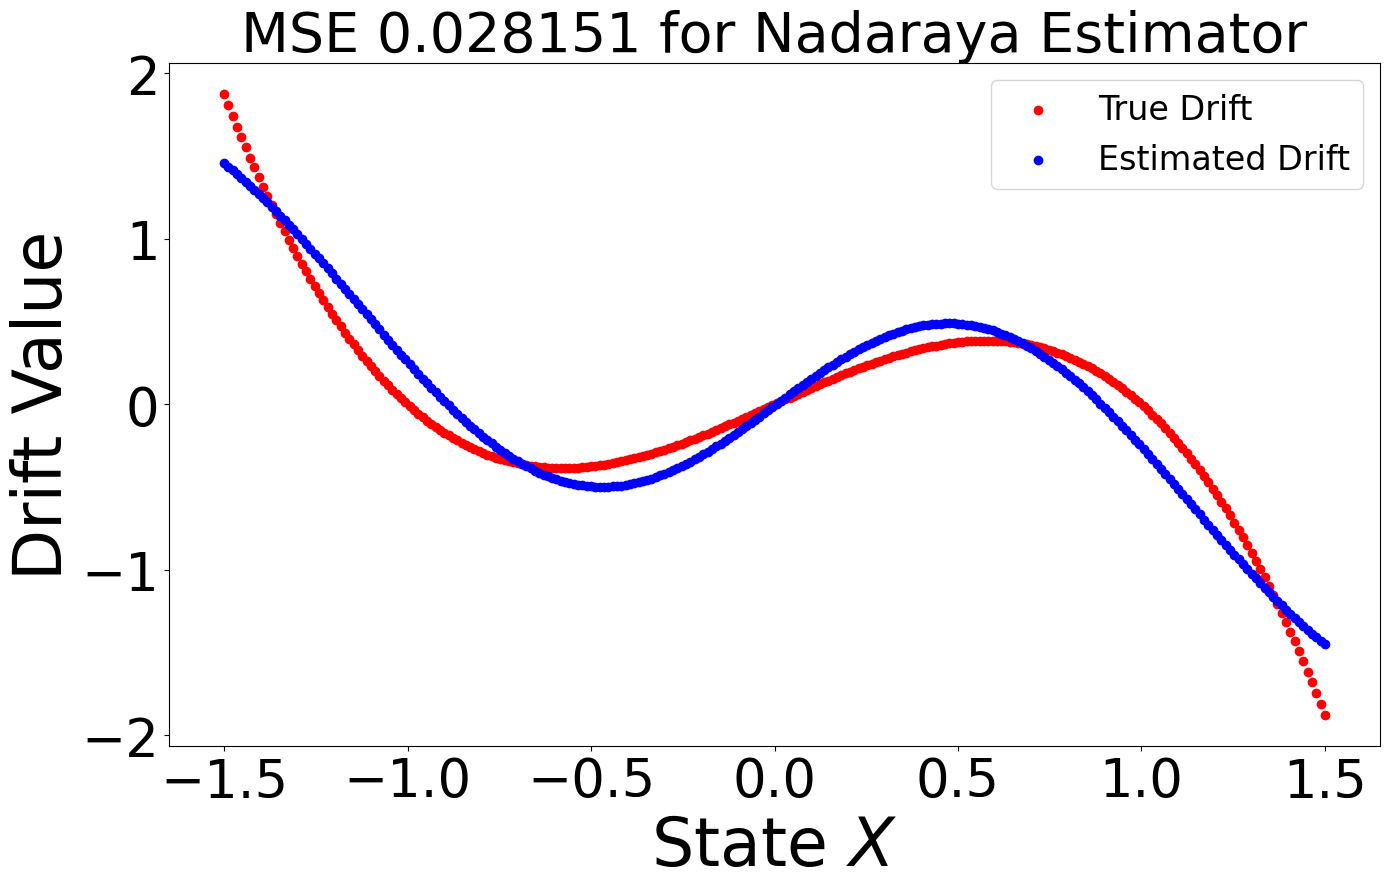

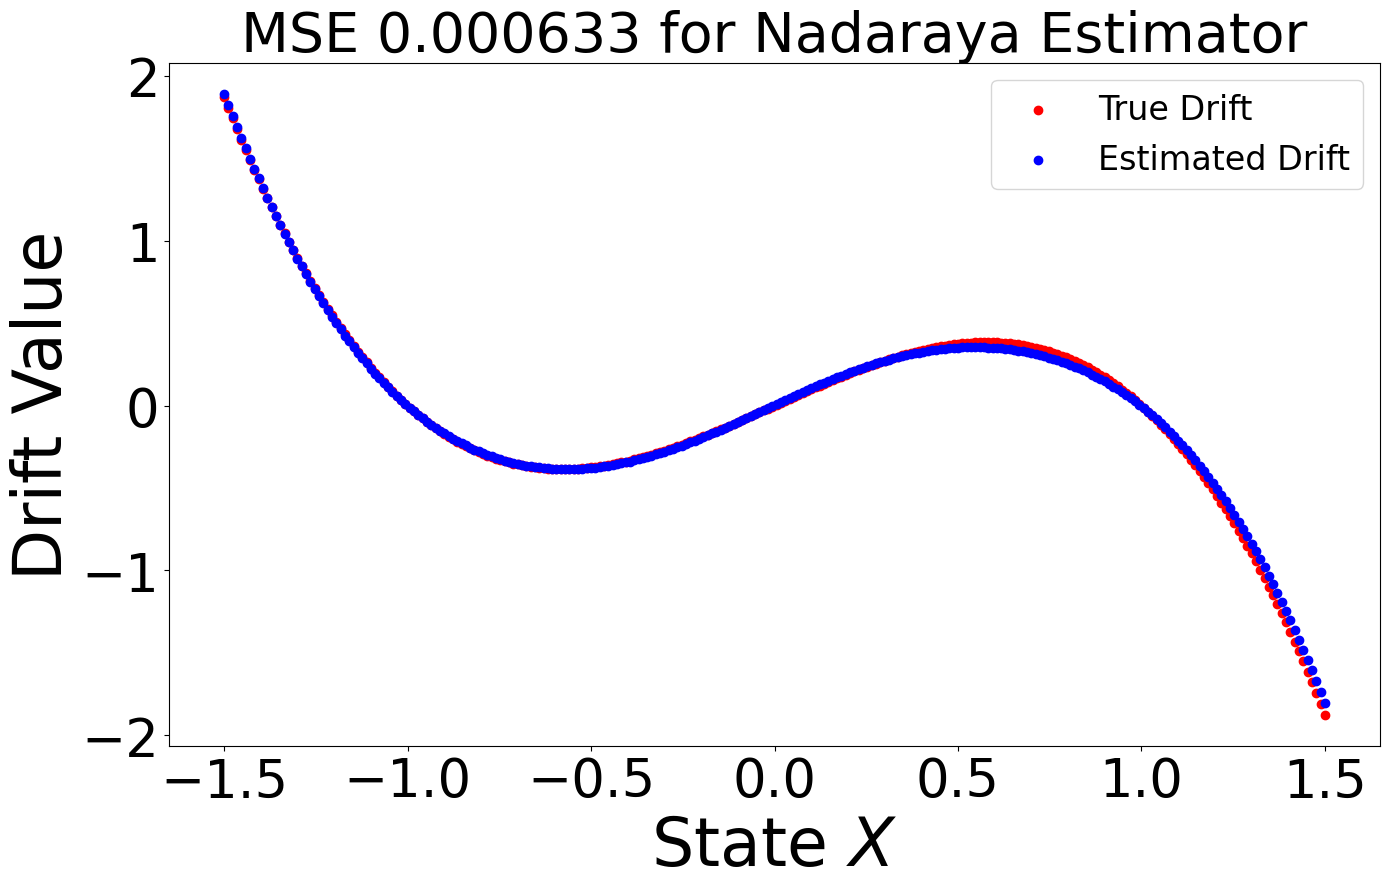

In [69]:
curr_mse = np.inf
for f_idx in range(len(keepfiles)):
    R = Rs[f_idx]
    f = keepfiles[f_idx]
    try:
        is_drift = np.load(f).flatten()
        mse = (rmse_ignore_nans(is_true_drift, is_drift))
        if mse < curr_mse:
            curr_mse = mse
            fig, ax = plt.subplots(figsize=(14,9))
            plt.scatter(vispaths, is_true_drift,label="True Drift", color="red")
            plt.scatter(vispaths, is_drift, label="Estimated Drift", color="blue")
            plt.legend(fontsize=18)
            plt.title(f"MSE {round(mse, 6)} for Nadaraya Estimator", fontsize=40)
            ax.tick_params(labelsize=38)
            plt.ylabel("Drift Value", fontsize=48)
            plt.xlabel(r"State $X$", fontsize=48)
            plt.legend(fontsize=24)
            plt.tight_layout()
            plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/Hermite_{ts_type}_DriftEvalExp_{R}R".replace(".","")+".png",  bbox_inches='tight')
            plt.show()
            plt.close()
    except ValueError as e:
        plt.close()
        continue


In [70]:
def get_drifttrack_files(config):
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        if "QuadSin" in ts_type:
            if "Hermite" in file and  "DriftTrack" in file and ts_type[:-1] in file and include in file and f"{config.sin_space_scale}c".replace(".", "") in file:
                print(file)
                if "true" in file:
                    true_files.append(root_dir+file)
                elif "local" in file:
                    local_files.append(root_dir+file)
        else:
            if "Hermite" in file and  "DriftTrack" in file and ts_type[:-1] in file and include in file:
                print(file)
                if "true" in file:
                    true_files.append(root_dir+file)
                elif "local" in file:
                    local_files.append(root_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    true_files = sorted(true_files, key=extract_R_number)
    local_files = sorted(local_files, key=extract_R_number)
    Rs = [extract_R_number(f) for f in true_files]
    return true_files, local_files, Rs

In [71]:
config = get_config()
true_files, local_files, Rs = get_drifttrack_files(config=config)
local_files

Hermite_fBiPot_DriftTrack_7R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
Hermite_fBiPot_DriftTrack_4R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
Hermite_fBiPot_DriftTrack_3R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy
Hermite_fBiPot_DriftTrack_2R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
Hermite_fBiPot_DriftTrack_8R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
Hermite_fBiPot_DriftTrack_3R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
Hermite_fBiPot_DriftTrack_2R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy
Hermite_fBiPot_DriftTrack_6R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
Hermite_fBiPot_DriftTrack_5R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
Hermite_fBiPot_DriftTrack_8R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy
Hermite_fBiPot_DriftTrack_6R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy
Hermite_fBiPot_DriftTrack_4R_10952NPath

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/Hermite_fBiPot_DriftTrack_2R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/Hermite_fBiPot_DriftTrack_3R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/Hermite_fBiPot_DriftTrack_4R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/Hermite_fBiPot_DriftTrack_5R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/Hermite_fBiPot_DriftTrack_6R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/Hermite_fBiPot_DriftTrack_7R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHub

0.00023548403731676854 0.0 inf 0
0.00023594260304077115 0.0 inf 1


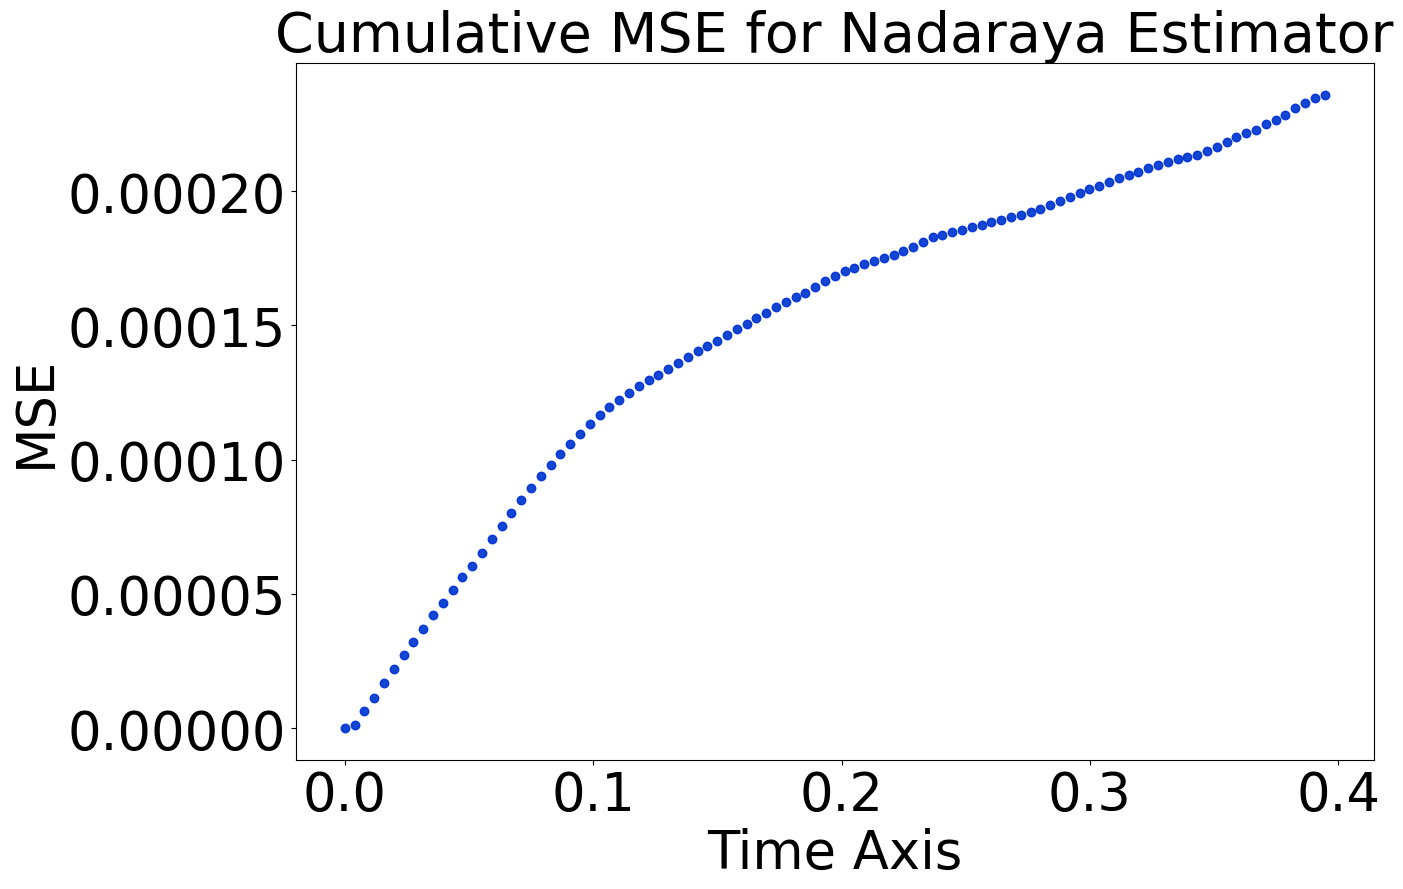

Final time cumulative MSE local-time error 0.00023594260304077115 with IQR ((0.00023594260304077107, 0.00023594260304077107))at bw 3

6.012070391362822e-05 0.0 0.00023594260304077115 2


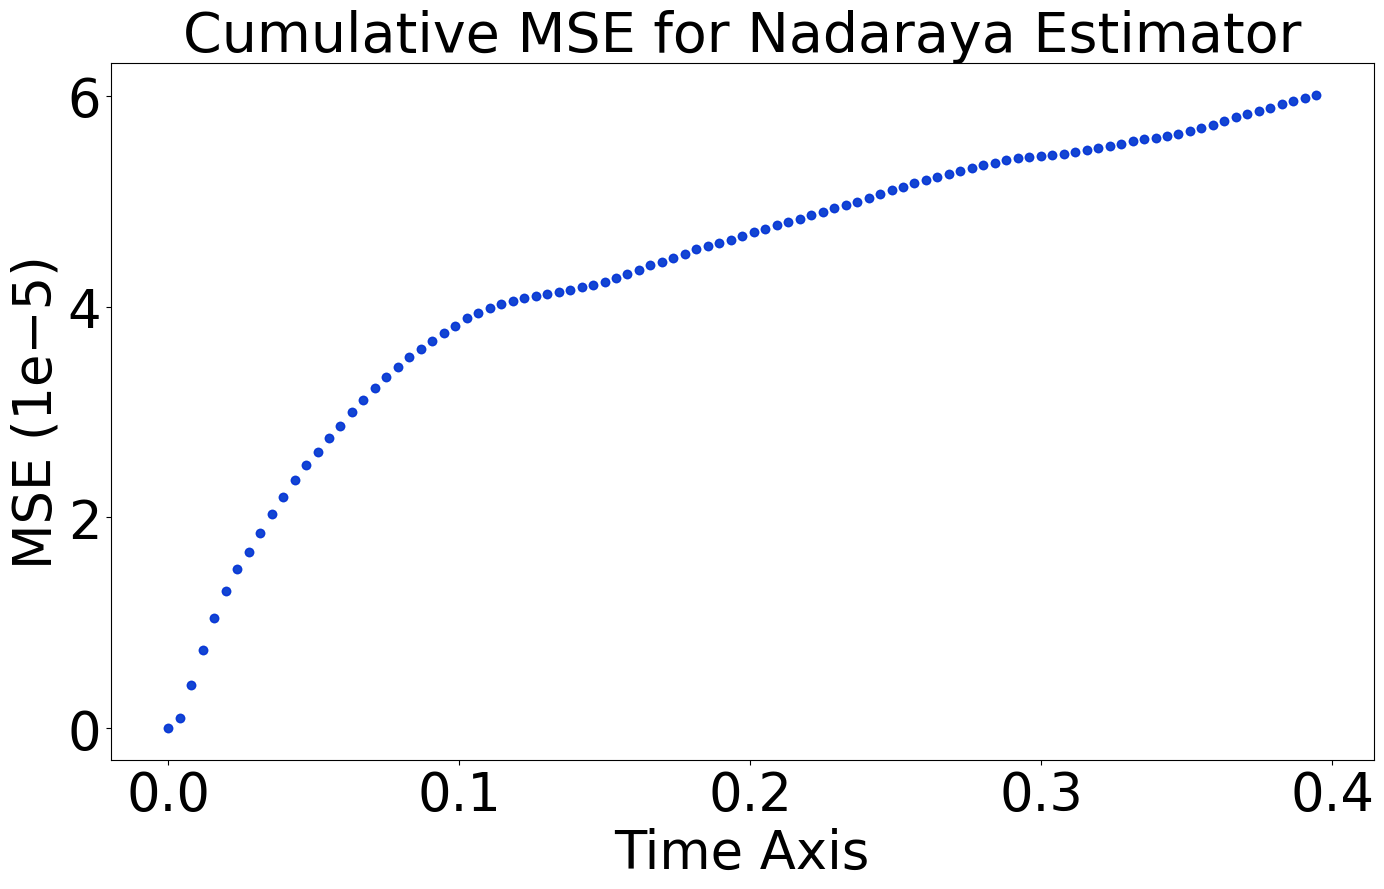

Final time cumulative MSE local-time error 6.012070391362822e-05 with IQR ((6.012070391362822e-05, 6.012070391362822e-05))at bw 4

6.009315774161933e-05 0.0 6.012070391362822e-05 3


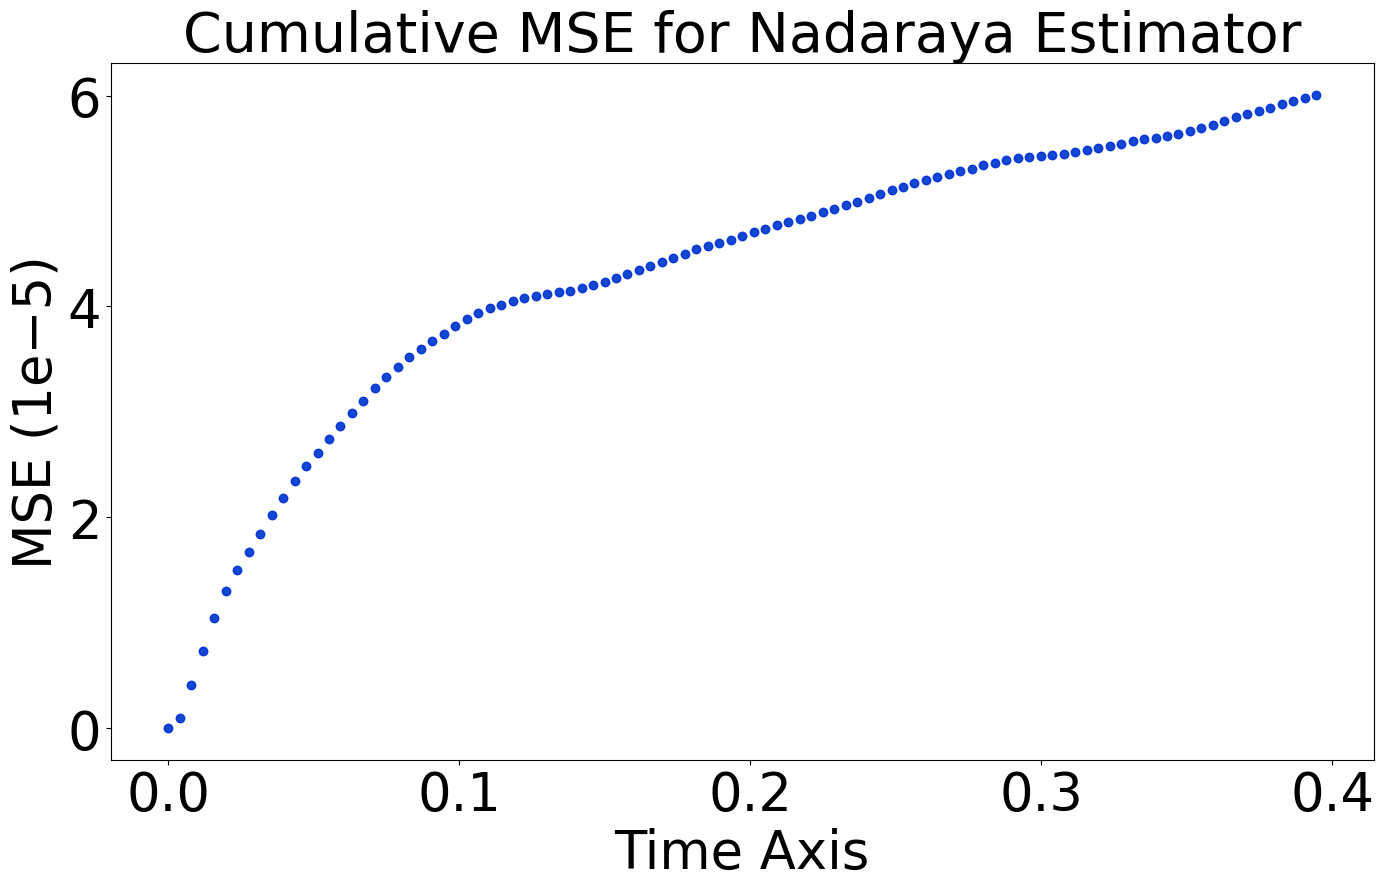

Final time cumulative MSE local-time error 6.009315774161933e-05 with IQR ((6.0093157741619336e-05, 6.0093157741619336e-05))at bw 5

4.128199186812914e-06 0.0 6.009315774161933e-05 4


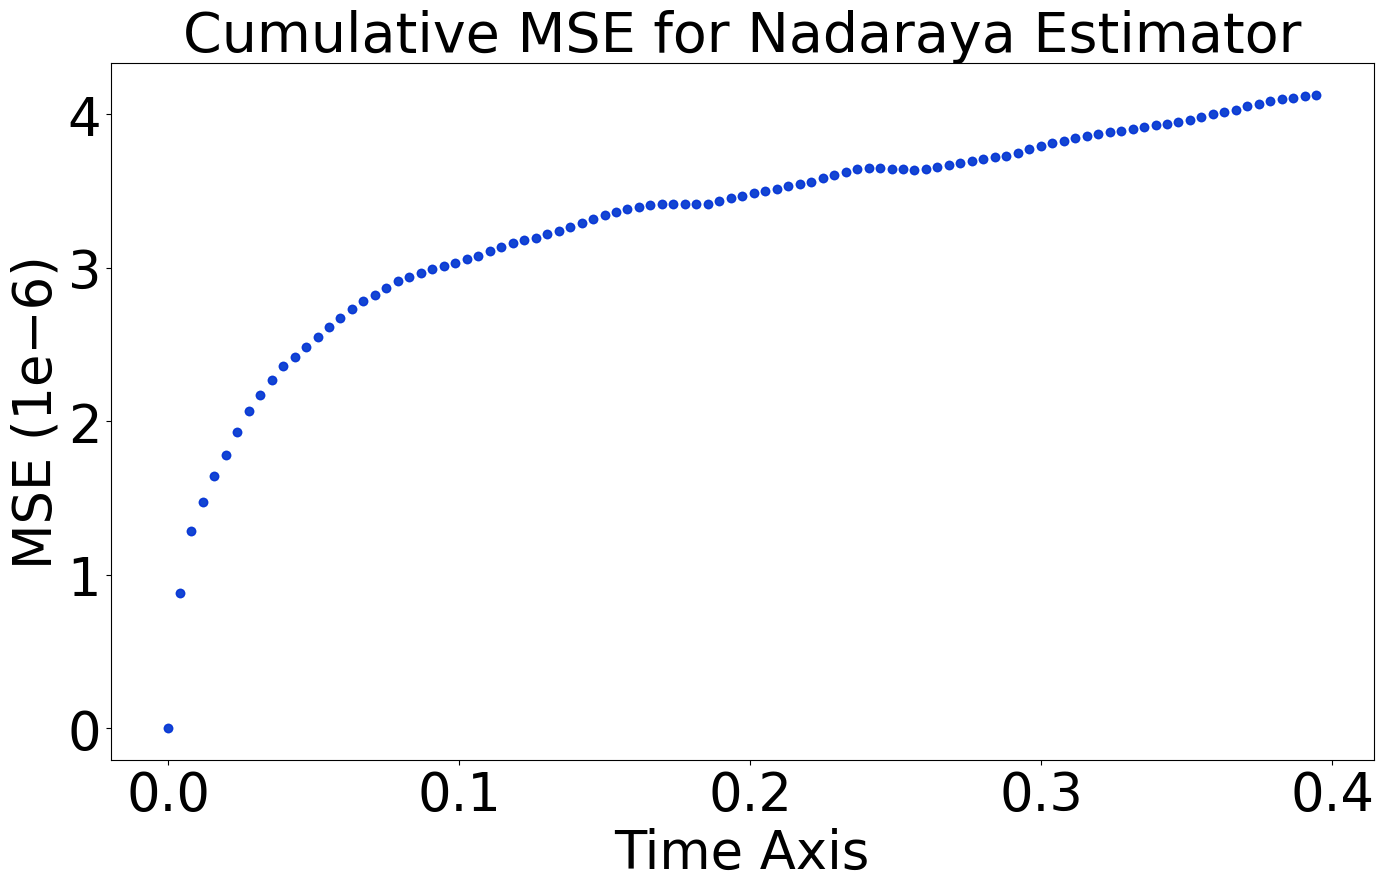

Final time cumulative MSE local-time error 4.128199186812914e-06 with IQR ((4.128199186812913e-06, 4.128199186812913e-06))at bw 6

4.157180500151917e-06 0.0 4.128199186812914e-06 5
1.296958949630278e-06 0.0 4.128199186812914e-06 6


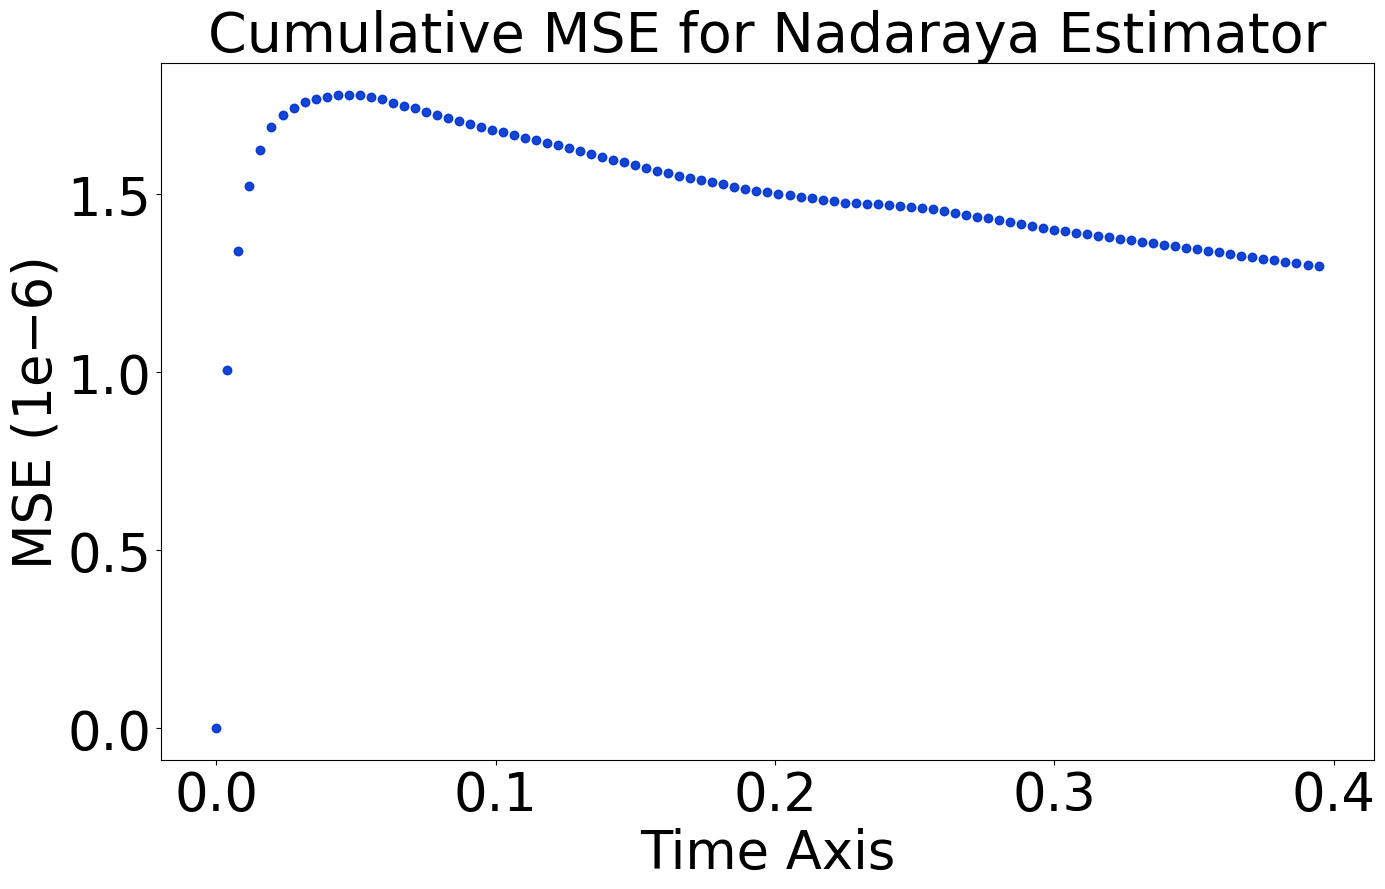

Final time cumulative MSE local-time error 1.296958949630278e-06 with IQR ((1.2969589496302786e-06, 1.2969589496302786e-06))at bw 8



In [72]:
curr_mse = np.inf
toSave = True
i = 0
for file in zip(*[true_files, local_files, Rs]):
    bw = file[-1]
    all_true_states = np.load(file[0])/np.sqrt(config.deltaT)
    all_local_states = np.load(file[1])/np.sqrt(config.deltaT)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        total_local_errors_minq = np.quantile((all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile((all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_mse, i)
        i += 1
        if i == 1: continue
        if total_local_errors[-1]  < curr_mse:
            miny = total_local_errors-total_local_errors_minq
            miny[miny < 0.] = 0.
            maxy = total_local_errors_maxq-total_local_errors
            maxy[maxy < 0.] = 0.
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_mse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            plt.errorbar(time_steps,total_local_errors,yerr=[miny, maxy],xerr=None, fmt='o', color="blue", alpha=0.4)
            ax.set_title(f"Cumulative MSE for Nadaraya Estimator",fontsize=40)

            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)

            fig.canvas.draw()
            # Get the offset text (e.g., '1e-5')
            offset_text = ax.yaxis.get_offset_text().get_text()

            # Remove the offset text from the axis
            ax.yaxis.get_offset_text().set_visible(False)

            # Inject the scale into the y-axis label
            if offset_text:
                ax.set_ylabel(f'MSE ({offset_text})', fontsize=38)
            else:
                ax.set_ylabel('MSE', fontsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/Hermite_{ts_type}_DriftTrack_{R}R_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw}\n")